In [1]:
import torch
from torch import nn
import pandas as pd
import numpy as np
from scipy import sparse
import time

import matplotlib.pyplot as plt

from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
from torch.optim.swa_utils import AveragedModel
from tqdm import tqdm

from torch_lr_finder import LRFinder

import utils
from importlib import reload

reload(utils)

<module 'utils' from '/home/artemy/multimodal_proj/nb/utils.py'>

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print('Using GPU')
else:
    device = torch.device("cpu")

Using GPU


## Files

In [3]:
DATASET = 'cite'

data_dir = '/home/artemy/multimodal_proj/data/competition/'
log_dir = '/home/artemy/multimodal_proj/cur_model_tb'
o_dir = '/home/artemy/multimodal_proj/data/AE_predictions/'


if DATASET == 'multi':
    inputs_train_fn = data_dir + "atac_train.sparse.npz"
    targets_train_fn = data_dir + "gex_train.sparse.npz"
    inputs_test_fn = data_dir + "atac_test.sparse.npz"
    pred_file = o_dir + "multi_gex_pred_with_SVD.npy"
elif DATASET == 'cite':
    inputs_train_fn = data_dir + "cite_gex_train.sparse.npz"
    targets_train_fn = data_dir + "cite_adt_train.sparse.npz"
    inputs_test_fn = data_dir + "cite_gex_test.sparse.npz"
    pred_file = o_dir + "cite_adt_pred.npy"
    
    imputed_inputs_train_fn = data_dir + "cite_gex_train_magic.sparse.npz"
    imputed_inputs_test_fn = data_dir + "cite_gex_test_magic.sparse.npz"

## Model:

In [4]:
class MLP_Original_Multi(utils.CustomModel):
    def __init__(self,
                 input_dim: int,
                 output_dim: int,
                 sparsity_rho=0.05,
                 sparsity_beta=0.001,
                 **kwargs
    ):
        super().__init__()
        self.save_hyperparameters()
        
        
        modules = []
        input_dim = self.input_dim
        output_dim = 2000
        self.l1 = nn.Linear(input_dim, output_dim)
        self.bn1 = nn.BatchNorm1d(num_features=output_dim)  
        self.act1 = nn.SiLU()
        
        input_dim = output_dim
        output_dim = 2000
        self.l2 = nn.Linear(input_dim, output_dim)
        self.bn2 = nn.BatchNorm1d(num_features=output_dim)
        self.act2 = nn.SiLU()
        
        input_dim = output_dim
        output_dim = 2000
        self.l3 = nn.Linear(input_dim, output_dim)
        self.bn3 = nn.BatchNorm1d(num_features=output_dim)           
        self.act3 = nn.SiLU()
        
        input_dim = output_dim
        output_dim = 2000
        self.l4 = nn.Linear(input_dim, output_dim)
        self.bn4 = nn.BatchNorm1d(num_features=output_dim)           
        self.act4 = nn.SiLU()
        
        input_dim = output_dim
        output_dim = self.output_dim
        self.l5 = nn.Linear(input_dim, output_dim)
            
        self.net = nn.Sequential(self.l1, self.bn1, self.act1,
                                 self.l2, self.bn2, self.act2,
                                 self.l3, self.bn3, self.act3,
                                 self.l4, self.bn4, self.act4,
                                 self.l5) 
        self.net.apply(utils.init_weights)
    
    def forward(self, x):

        out = self.l1(x)
        out = self.bn1(out)
        out1 = self.act1(out)
        
        out = self.l2(out1)
        out = self.bn2(out)
        out2 = self.act2(out)
        
        out = self.l3(out2)
        out = self.bn3(out)
        out3 = self.act3(out)
        
        out = self.l4(out3)
        out = self.bn4(out)
        out4 = self.act4(out)
                        
        out = self.l5(out4)

        
        self.klloss = torch.tensor([0])
        if self.sparsity_beta != 0:
            for vals in [out1, out2, out3, out4]:
                self.klloss += self.kl_divergence(self.rho, vals)
            
        return out

In [5]:
class MLP_SVD_and_Original(utils.CustomModel):
    def __init__(self,
                 input_dim: int,
                 output_dim: int,
                 sparsity_rho=0.05,
                 sparsity_beta=0.001,
                 n_components = 128,
                 **kwargs
    ):
        super().__init__()
        self.save_hyperparameters()
        
        
        modules = []
        input_dim = self.input_dim - self.n_components
        output_dim1 = 512
        self.l1 = nn.Linear(input_dim, output_dim1)
        self.bn1 = nn.BatchNorm1d(num_features=output_dim1)  
        self.act1 = nn.SiLU()
        
        input_dim = output_dim1
        output_dim1_2 = 512
        self.l1_2 = nn.Linear(input_dim, output_dim1_2)
        self.bn1_2 = nn.BatchNorm1d(num_features=output_dim1_2)  
        self.act1_2 = nn.SiLU()
        
        input_dim = output_dim1_2 + self.n_components
        output_dim2 = 512 + self.n_components
        self.l2 = nn.Linear(input_dim, output_dim2)
        self.bn2 = nn.BatchNorm1d(num_features=output_dim2)
        self.act2 = nn.SiLU()
        
        input_dim = output_dim2
        output_dim3 = 256
        self.l3 = nn.Linear(input_dim, output_dim3)
        self.bn3 = nn.BatchNorm1d(num_features=output_dim3)           
        self.act3 = nn.SiLU()
        
        input_dim = output_dim3
        output_dim4 = 256
        self.l4 = nn.Linear(input_dim, output_dim4)
        self.bn4 = nn.BatchNorm1d(num_features=output_dim4)           
        self.act4 = nn.SiLU()
        
        input_dim = output_dim4 + output_dim3 + output_dim2
        output_dim = self.output_dim
        self.l5 = nn.Linear(input_dim, output_dim)

            
        self.net = nn.Sequential(self.l1, self.bn1, self.act1,
                                 self.l1_2, self.bn1_2, self.act1_2,
                                 self.l2, self.bn2, self.act2,
                                 self.l3, self.bn3, self.act3,
                                 self.l4, self.bn4, self.act4,
                                 self.l5)
        self.net.apply(utils.init_weights)
    
    def forward(self, x):

        out = self.l1(x[:,self.n_components:])
        out = self.bn1(out)
        out1 = self.act1(out)
        
        out = self.l1_2(out1)
        out = self.bn1_2(out)
        out1 = self.act1_2(out)
        
        out = torch.concat((x[:, :self.n_components], out1), 1)
        
        out = self.l2(out)
        out = self.bn2(out)
        out2 = self.act2(out)
        
        out = self.l3(out2)
        out = self.bn3(out)
        out3 = self.act3(out)
        
        out = self.l4(out3)
        out = self.bn4(out)
        out4 = self.act4(out)
                
        out = torch.concat((out2, out3, out4), 1)
                
        out = self.l5(out)

        
        self.klloss = 0
        if self.sparsity_beta != 0:
            for vals in [out1, out2, out3, out4]:
                self.klloss += self.kl_divergence(self.rho, vals)
            
        return out
    
    def loss(self, y, y_hat):
        l = torch.tensor([0])
        l += self.MSE_loss(y, y_hat)
        l += torch.sum(torch.abs(list(self.parameters())[0])) * 1e-2
        return l

In [6]:
class MLP_Cite_SVD(utils.CustomModel):
    def __init__(self,
                 input_dim: int,
                 output_dim: int,
                 sparsity_rho=0.05,
                 sparsity_beta=0.001,
                 **kwargs 
    ):
        super().__init__()
        self.save_hyperparameters()
        
        
        modules = []
        input_dim = self.input_dim
        output_dim1 = 512
        self.l1 = nn.Linear(input_dim, output_dim1)
        self.bn1 = nn.BatchNorm1d(num_features=output_dim1)          
        self.act1 = nn.SiLU()
        
        input_dim = output_dim1
        output_dim2 = 256 
        self.l2 = nn.Linear(input_dim, output_dim2)
        self.bn2 = nn.BatchNorm1d(num_features=output_dim2)          
        self.act2 = nn.SiLU()
        
        input_dim = output_dim2
        output_dim3 = 128 
        self.l3 = nn.Linear(input_dim, output_dim3)
        self.bn3 = nn.BatchNorm1d(num_features=output_dim3)           
        self.act3 = nn.SiLU()
        
        input_dim = output_dim3
        output_dim4 = 64 
        self.l4 = nn.Linear(input_dim, output_dim4)
        self.bn4 = nn.BatchNorm1d(num_features=output_dim4)           
        self.act4 = nn.SiLU()
        
        input_dim = output_dim1 + output_dim2 + output_dim3 + output_dim4
        output_dim5 = self.output_dim
        self.l5 = nn.Linear(input_dim, output_dim5)
        
        self.net = nn.Sequential(self.l1, self.bn1, self.act1,
                                 self.l2, self.bn2, self.act2,
                                 self.l3, self.bn3, self.act3,
                                 self.l4, self.bn4, self.act4,
                                 self.l5) 
        self.net.apply(utils.init_weights)
    
    def forward(self, x):

        out = self.l1(x)
        out = self.bn1(out)
        out1 = self.act1(out)
        
        out = self.l2(out1)
        out = self.bn2(out)
        out2 = self.act2(out)
        
        out = self.l3(out2)
        out = self.bn3(out)
        out3 = self.act3(out)
        
        out = self.l4(out3)
        out = self.bn4(out)
        out4 = self.act4(out)
        
        out = torch.concat((out1, out2, out3, out4), 1)
                
        out = self.l5(out)

        self.klloss = torch.tensor([0])
        if self.sparsity_beta != 0:
            for vals in [out1, out2, out3, out4]:
                self.klloss += self.kl_divergence(self.rho, vals)
            
        return out

## Load data

In [7]:
load_data = 1
if load_data:
    inputs = utils.load_sparse_data(inputs_train_fn)
    targets = utils.load_sparse_data(targets_train_fn)
    inputs_test = utils.load_sparse_data(inputs_test_fn)
    if DATASET == 'cite':
        imputed_inputs_cite = utils.load_sparse_data(imputed_inputs_train_fn)
        imputed_inputs_test_cite = utils.load_sparse_data(imputed_inputs_test_fn)

In [8]:
from sklearn.decomposition import TruncatedSVD, NMF, PCA, KernelPCA

only_important_genes = False
batch_size = 2048
num_workers = 1
do_svd = True


if not do_svd:
    if DATASET == 'cite':
        inputs_processed = inputs
        test_loader = inputs_test
    else:
        inputs_processed = imputed_inputs_cite
        inputs_test_processed = imputed_inputs_test_cite
elif DATASET == 'cite':
    n_components = 48
    svd =  TruncatedSVD(n_components=n_components, random_state=1)
    inputs_combined = np.concatenate((inputs, inputs_test))
    inputs_combined = svd.fit_transform(inputs_combined)
    inputs_processed = inputs_combined[:len(inputs)]
    inputs_test_processed = inputs_combined[-len(inputs_test):]
    
    if only_important_genes:
        cite_inputs_features = pd.read_csv(data_dir + 'cite_inputs_features.csv').iloc[:, 0].tolist()
        important_cols = ['ENSG00000114013_CD86', 'ENSG00000120217_CD274', 'ENSG00000196776_CD47', 'ENSG00000117091_CD48', 'ENSG00000101017_CD40', 'ENSG00000102245_CD40LG', 'ENSG00000169442_CD52', 'ENSG00000117528_ABCD3', 'ENSG00000168014_C2CD3', 'ENSG00000167851_CD300A', 'ENSG00000167850_CD300C', 'ENSG00000186407_CD300E', 'ENSG00000178789_CD300LB', 'ENSG00000186074_CD300LF', 'ENSG00000241399_CD302', 'ENSG00000167775_CD320', 'ENSG00000105383_CD33', 'ENSG00000174059_CD34', 'ENSG00000135218_CD36', 'ENSG00000104894_CD37', 'ENSG00000004468_CD38', 'ENSG00000167286_CD3D', 'ENSG00000198851_CD3E', 'ENSG00000117877_CD3EAP', 'ENSG00000074696_HACD3', 'ENSG00000015676_NUDCD3', 'ENSG00000161714_PLCD3', 'ENSG00000132300_PTCD3', 'ENSG00000082014_SMARCD3', 'ENSG00000121594_CD80', 'ENSG00000110651_CD81', 'ENSG00000238184_CD81-AS1', 'ENSG00000085117_CD82', 'ENSG00000112149_CD83', 'ENSG00000066294_CD84', 'ENSG00000114013_CD86', 'ENSG00000172116_CD8B', 'ENSG00000254126_CD8B2', 'ENSG00000177455_CD19', 'ENSG00000105383_CD33', 'ENSG00000173762_CD7', 'ENSG00000125726_CD70', 'ENSG00000137101_CD72', 'ENSG00000019582_CD74', 'ENSG00000105369_CD79A', 'ENSG00000007312_CD79B', 'ENSG00000090470_PDCD7', 'ENSG00000119688_ABCD4', 'ENSG00000010610_CD4', 'ENSG00000101017_CD40', 'ENSG00000102245_CD40LG', 'ENSG00000026508_CD44', 'ENSG00000117335_CD46', 'ENSG00000196776_CD47', 'ENSG00000117091_CD48', 'ENSG00000188921_HACD4', 'ENSG00000150593_PDCD4', 'ENSG00000203497_PDCD4-AS1', 'ENSG00000115556_PLCD4', 'ENSG00000026508_CD44', 'ENSG00000170458_CD14', 'ENSG00000117281_CD160', 'ENSG00000177575_CD163', 'ENSG00000135535_CD164', 'ENSG00000091972_CD200', 'ENSG00000163606_CD200R1', 'ENSG00000206531_CD200R1L', 'ENSG00000182685_BRICD5', 'ENSG00000111731_C2CD5', 'ENSG00000169442_CD52', 'ENSG00000143119_CD53', 'ENSG00000196352_CD55', 'ENSG00000116815_CD58', 'ENSG00000085063_CD59', 'ENSG00000105185_PDCD5', 'ENSG00000255909_PDCD5P1', 'ENSG00000145284_SCD5', 'ENSG00000167775_CD320', 'ENSG00000110848_CD69', 'ENSG00000139187_KLRG1', 'ENSG00000139193_CD27', 'ENSG00000215039_CD27-AS1', 'ENSG00000120217_CD274', 'ENSG00000103855_CD276', 'ENSG00000204287_HLA-DRA', 'ENSG00000196126_HLA-DRB1', 'ENSG00000198502_HLA-DRB5', 'ENSG00000229391_HLA-DRB6', 'ENSG00000116815_CD58', 'ENSG00000168329_CX3CR1', 'ENSG00000272398_CD24', 'ENSG00000122223_CD244', 'ENSG00000198821_CD247', 'ENSG00000122223_CD244', 'ENSG00000177575_CD163', 'ENSG00000112149_CD83', 'ENSG00000185963_BICD2', 'ENSG00000157617_C2CD2', 'ENSG00000172375_C2CD2L', 'ENSG00000116824_CD2', 'ENSG00000091972_CD200', 'ENSG00000163606_CD200R1', 'ENSG00000206531_CD200R1L', 'ENSG00000012124_CD22', 'ENSG00000150637_CD226', 'ENSG00000272398_CD24', 'ENSG00000122223_CD244', 'ENSG00000198821_CD247', 'ENSG00000139193_CD27', 'ENSG00000215039_CD27-AS1', 'ENSG00000120217_CD274', 'ENSG00000103855_CD276', 'ENSG00000198087_CD2AP', 'ENSG00000169217_CD2BP2', 'ENSG00000144554_FANCD2', 'ENSG00000206527_HACD2', 'ENSG00000170584_NUDCD2', 'ENSG00000071994_PDCD2', 'ENSG00000126249_PDCD2L', 'ENSG00000049883_PTCD2', 'ENSG00000186193_SAPCD2', 'ENSG00000108604_SMARCD2', 'ENSG00000185561_TLCD2', 'ENSG00000075035_WSCD2', 'ENSG00000150637_CD226', 'ENSG00000110651_CD81', 'ENSG00000238184_CD81-AS1', 'ENSG00000134061_CD180', 'ENSG00000004468_CD38', 'ENSG00000012124_CD22', 'ENSG00000150637_CD226', 'ENSG00000135404_CD63', 'ENSG00000135218_CD36', 'ENSG00000137101_CD72', 'ENSG00000125810_CD93', 'ENSG00000010278_CD9', 'ENSG00000125810_CD93', 'ENSG00000153283_CD96', 'ENSG00000002586_CD99', 'ENSG00000102181_CD99L2', 'ENSG00000223773_CD99P1', 'ENSG00000204592_HLA-E', 'ENSG00000085117_CD82', 'ENSG00000134256_CD101']
        cell_cycle_genes = ['ENSG00000011426_ANLN', 'ENSG00000143401_ANP32E', 'ENSG00000156802_ATAD2', 'ENSG00000087586_AURKA', 'ENSG00000178999_AURKB', 'ENSG00000089685_BIRC5', 'ENSG00000197299_BLM', 'ENSG00000136492_BRIP1', 'ENSG00000169679_BUB1', 'ENSG00000118412_CASP8AP2', 'ENSG00000094916_CBX5', 'ENSG00000157456_CCNB2', 'ENSG00000175305_CCNE2', 'ENSG00000117399_CDC20', 'ENSG00000158402_CDC25C', 'ENSG00000093009_CDC45', 'ENSG00000094804_CDC6', 'ENSG00000184661_CDCA2', 'ENSG00000111665_CDCA3', 'ENSG00000144354_CDCA7', 'ENSG00000134690_CDCA8', 'ENSG00000170312_CDK1', 'ENSG00000115163_CENPA', 'ENSG00000138778_CENPE', 'ENSG00000117724_CENPF', 'ENSG00000151725_CENPU', 'ENSG00000159259_CHAF1B', 'ENSG00000136108_CKAP2', 'ENSG00000169607_CKAP2L', 'ENSG00000175216_CKAP5', 'ENSG00000173207_CKS1B', 'ENSG00000123975_CKS2', 'ENSG00000092853_CLSPN', 'ENSG00000102974_CTCF', 'ENSG00000126787_DLGAP5', 'ENSG00000136982_DSCC1', 'ENSG00000143476_DTL', 'ENSG00000129173_E2F8', 'ENSG00000114346_ECT2', 'ENSG00000174371_EXO1', 'ENSG00000168496_FEN1', 'ENSG00000092140_G2E3', 'ENSG00000139354_GAS2L3', 'ENSG00000131153_GINS2', 'ENSG00000112312_GMNN', 'ENSG00000075218_GTSE1', 'ENSG00000119969_HELLS', 'ENSG00000123485_HJURP', 'ENSG00000164104_HMGB2', 'ENSG00000072571_HMMR', 'ENSG00000189159_JPT1', 'ENSG00000138160_KIF11', 'ENSG00000138182_KIF20B', 'ENSG00000137807_KIF23', 'ENSG00000142945_KIF2C', 'ENSG00000143815_LBR', 'ENSG00000073111_MCM2', 'ENSG00000104738_MCM4', 'ENSG00000100297_MCM5', 'ENSG00000076003_MCM6', 'ENSG00000148773_MKI67', 'ENSG00000095002_MSH2', 'ENSG00000132780_NASP', 'ENSG00000010292_NCAPD2', 'ENSG00000080986_NDC80', 'ENSG00000117650_NEK2', 'ENSG00000143228_NUF2', 'ENSG00000137804_NUSAP1', 'ENSG00000132646_PCNA', 'ENSG00000129195_PIMREG', 'ENSG00000101868_POLA1', 'ENSG00000077514_POLD3', 'ENSG00000198056_PRIM1', 'ENSG00000134222_PSRC1', 'ENSG00000051180_RAD51', 'ENSG00000111247_RAD51AP1', 'ENSG00000100401_RANGAP1', 'ENSG00000049541_RFC2', 'ENSG00000117748_RPA2', 'ENSG00000167325_RRM1', 'ENSG00000171848_RRM2', 'ENSG00000163950_SLBP', 'ENSG00000113810_SMC4', 'ENSG00000013810_TACC3', 'ENSG00000075131_TIPIN', 'ENSG00000120802_TMPO', 'ENSG00000131747_TOP2A', 'ENSG00000088325_TPX2', 'ENSG00000112742_TTK', 'ENSG00000188229_TUBB4B', 'ENSG00000176890_TYMS', 'ENSG00000175063_UBE2C', 'ENSG00000012963_UBR7', 'ENSG00000276043_UHRF1', 'ENSG00000076248_UNG', 'ENSG00000162607_USP1', 'ENSG00000092470_WDR76']
        coding_pos = [cite_inputs_features.index(gene) for gene in important_cols]
        coding_pos = list(set(coding_pos))
        rna_levels = imputed_inputs_cite[:, coding_pos]
        rna_levels_test = imputed_inputs_test_cite[:, coding_pos]
    else:
        rna_levels = imputed_inputs_cite
        rna_levels_test = imputed_inputs_test_cite
    
    inputs_processed = np.concatenate((inputs_processed, rna_levels), 1)
    inputs_test_processed = np.concatenate((inputs_test_processed, rna_levels_test), 1)
else: 
    n_components = 128
    svd =  TruncatedSVD(n_components=n_components, random_state=1)
    inputs_combined = np.concatenate((inputs, inputs_test))
    inputs_combined = svd.fit_transform(inputs_combined)
    inputs_processed = inputs_combined[:len(inputs)]
    inputs_test_processed = inputs_combined[-len(inputs_test):]
    
    inputs_processed = np.concatenate((inputs_processed, inputs), 1)
    inputs_test_processed = np.concatenate((inputs_test_processed, inputs_test), 1)  
    #sparse.save_npz(data_dir + "atac_train_svd.sparse.npz", sparse.csr_matrix(np.matrix(inputs_processed)))
    #sparse.save_npz(data_dir + "atac_test_svd.sparse.npz", sparse.csr_matrix(np.matrix(inputs_processed)))
    
train_loader, val_loader = utils.make_loaders(inputs_processed, targets, batch_size=batch_size, num_workers=num_workers)
test_loader = utils.make_loaders(inputs_test_processed, batch_size=batch_size, num_workers=num_workers)
  

## Train model

In [11]:
# generic parameters
trainer_params = {
                  'use_one_cycle': 1,
                  'use_swa': 0,
                  'inputs_fn': inputs_train_fn,
                  'targets_fn': targets_train_fn,
                  'device': device, 
                  'wd': 0.02,
                  'lr': 1e-2 
                 }

# best variant
trainer_params['use_one_cycle'] = 1

# doesn't help
trainer_params['use_swa'] = 0
trainer_params['swa_start'] = 5

# best
model = MLP_SVD_and_Original
model_params = {'n_components': 48}

trainer_params['max_epochs'] = 20
trainer_params['max_schedule_epoch'] = 20 # decrease if you wan't the schedule to finish earlier
trainer_params['min_lr'] = 1e-7 # which lr use after the schedule has stopped

# sparsity promoting parameters
trainer_params['sparsity_beta'] = 0
trainer_params['sparsity_rho'] = 0.05

# regularization
trainer_params['l1_weight'] = 0
trainer_params['l2_weight'] = 0


if trainer_params['use_swa']:
    model = AveragedModel(model)

In [12]:
configure_trainer = True
if configure_trainer:
    writer = SummaryWriter(log_dir=log_dir)
    trainer = utils.Trainer(**trainer_params, writer = writer)
    trainer.add_train_loader(train_loader)
    trainer.add_val_loader(val_loader)

In [13]:
torch.cuda.empty_cache()

In [14]:
%%time
train_model = 1
if train_model:
    trainer.add_model(model)
    trainer.fit(do_validation=True, subset_train=-1)    

Using TensorBoard for output


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:58<00:00,  5.91s/it]

Training loss: 3.538
Training cor: 0.901
Validation loss: 2.779
Validation cor: 0.897
CPU times: user 16min 29s, sys: 1min 9s, total: 17min 38s
Wall time: 1min 59s


In [16]:
model_file = f'{o_dir}model_{DATASET}.pt'

save_model = 1
if save_model:
    trainer.save_model(model_file)

In [17]:
plot_progress_True = False
if plot_progress_True:
    utils.plot_progress(trainer)

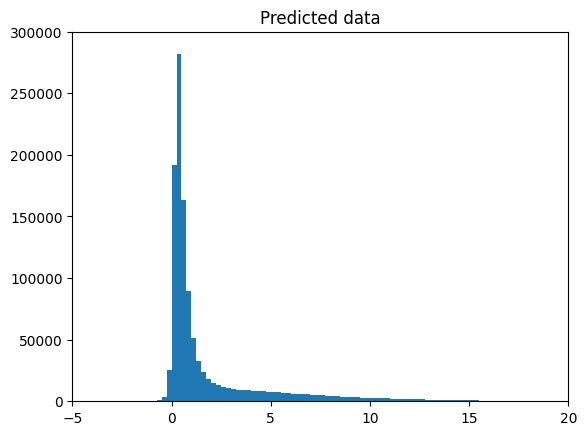

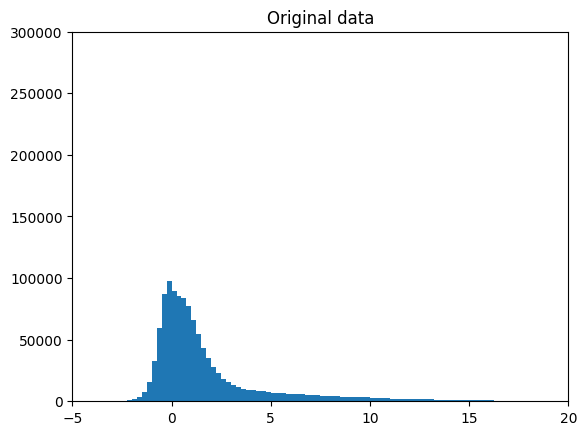

In [18]:
analyze_pred = 1
if analyze_pred:
    model_params = {}
    model_params['input_dim'] = trainer.train_loader.input_dim
    model_params['output_dim'] = trainer.train_loader.output_dim
    trainer.add_model(model, model_params)
    trainer.load_model(model_file)
    rna_pred, rna_orig = trainer.analyze_model(trainer.val_loader)
    #plot_model_analysis(rna_pred, rna_orig)

    plt.hist(rna_pred.flatten(), bins=100, range=(-5, 20))
    plt.title('Predicted data')
    plt.ylim((0, 300000))
    plt.xlim((-5, 20))
    plt.show()
    plt.hist(rna_orig.flatten(), bins=100, range=(-5, 20))
    plt.ylim((0, 300000))
    plt.xlim((-5, 20))
    plt.title('Original data')

## RUN LRRT

In [ ]:
def run_lrrt(train_loader, val_loader, batch_size=2048, end_lr=10, min_lr=1e-7, wd=2e-2, validation=False, device='cuda'):
    def criterion(predicted, orig):
        loss_fn = nn.MSELoss()
        l = loss_fn(orig, predicted[0])
        return l
    
    model_inst = model(train_loader.input_dim, train_loader.output_dim)
    optimizer = torch.optim.AdamW(model_inst.parameters(), lr=min_lr, weight_decay=wd)
    lr_finder = LRFinder(model_inst, optimizer, criterion, device=device)
    
    if validation:
        lr_finder.range_test(train_loader, end_lr=end_lr, num_iter=100, val_loader=val_loader)
    else:
        lr_finder.range_test(train_loader, end_lr=end_lr, num_iter=100)
        
    lr_finder.plot(log_lr=True)

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.04E-03


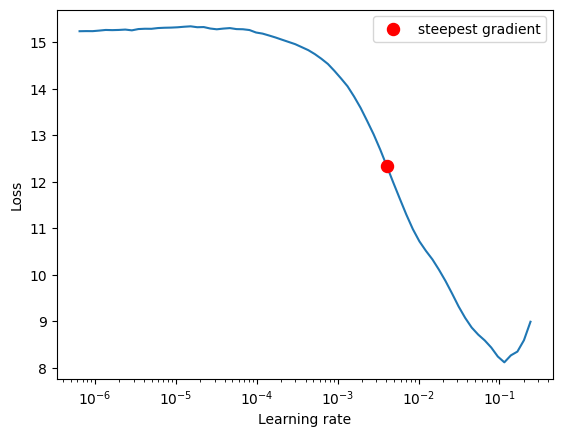

In [40]:
lrrt_on_train = 1
if lrrt_on_train:
    run_lrrt(train_loader, val_loader, end_lr=10)

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.06E-04


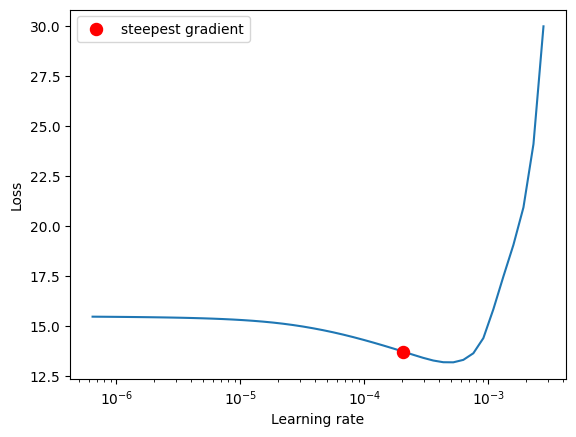

In [9]:
lrrt_on_val = 1
if lrrt_on_val:
    run_lrrt(train_loader, val_loader, validation=True)


In [13]:
inputs_test = load_sparse_data(inputs_test_fn)

## Make predictions

In [19]:
make_predictions = True
if make_predictions:
    model_params['input_dim'] = trainer.train_loader.input_dim
    model_params['output_dim'] = trainer.train_loader.output_dim
    trainer.add_model(model, model_params)
    trainer.load_model(model_file)
    
    
    outputs = trainer.transform(test_loader)

    with open(pred_file, 'wb') as f:
        np.save(f, outputs)